See code at https://github.com/google-research/vision_transformer/

See paper at https://arxiv.org/abs/2010.11929

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

##### Copyright 2020 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [1]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias/vision_transformer'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Mounted at /gdrive

Changed CWD to "/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias/vision_transformer"


In [2]:
!pip install -qr ./vit_jax/requirements.txt
!pip install tfa-nightly
!pip install tensorflow_io

     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 153kB 9.7MB/s 
     |████████████████████████████████| 92kB 5.0MB/s 
     |████████████████████████████████| 137.3MB 71kB/s 
     |████████████████████████████████| 4.3MB 46.4MB/s 
     |████████████████████████████████| 747kB 6.2MB/s 
     |████████████████████████████████| 22.4MB 6.4MB/s 


### Imports

In [2]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/*

      65 B  2020-10-21T07:59:00Z  gs://vit_models/README.txt

gs://vit_models/imagenet21k+imagenet2012/:
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
439.85 MiB  2020-11-24T13:40:46Z  gs://vit_models/imagenet21k/R50-ViT-B_16.npz
393.69 MiB  2020-10-22T21:38:39Z  gs://vit_models/imagenet21k/ViT-B_16.npz
400.01 MiB  2020-11-02T08:30:56Z  gs://vit_models/imagenet21k/ViT-B_32.npz
  2.46 GiB  2020-11-03T10:46:11Z  gs://vit_models/imagenet21k/ViT-H_14.npz
  1.22 GiB  2020-11-09T1

In [25]:
# Specify model.
model = 'ViT-B_32'

In [4]:
#@markdown TPU setup : Boilerplate for connecting JAX to TPU.

import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  # Make sure the Colab Runtime is set to Accelerator: TPU.
  import requests
  if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver0.1-dev20191206'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

  # The following is required to use TPU Driver as JAX's backend.
  from jax.config import config
  config.FLAGS.jax_xla_backend = "tpu_driver"
  config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
  print('Registered TPU:', config.FLAGS.jax_backend_target)
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Registered TPU: grpc://10.2.104.26:8470


In [6]:
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import tensorflow_addons as tfa
import tensorflow as tf
import flax.jax_utils as flax_utils
import random
import cv2
import csv
import re
import os
import tensorflow_io as tfio

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=2, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=3, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=4, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=5, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=6, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=7, host_id=0, coords=(0,0,0), core_on_chip=0)]

In [7]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

# Adding simclr directory to path
sys.path.append('../simclr/')

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from vit_jax import checkpoint
from vit_jax import hyper
from vit_jax import input_pipeline
from vit_jax import logging
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train

# Importing data-augmentation functions
import data_util

logger = logging.setup_logger('./logs')

In [8]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [9]:
dataset = 'cifar10'
batch_size = 512  # Reduce to 256 if running on a single GPU.


In [10]:
# Note the datasets are configured in input_pipeline.DATASET_PRESETS
# Have a look in the editor at the right.
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
# tf.data.Datset for training, infinite repeats.
ds_train = input_pipeline.get_data(
    dataset=dataset, mode='train', repeats=None, batch_size=batch_size,
)
# tf.data.Datset for evaluation, single repeat.
ds_test = input_pipeline.get_data(
    dataset=dataset, mode='test', repeats=1, batch_size=batch_size,
)

2020-11-28 21:31:45,809 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
2020-11-28 21:31:46,404 [INFO] absl: Load dataset info from /tmp/tmp9woj5jwdtfds
2020-11-28 21:31:46,413 [INFO] absl: Field info.citation from disk and from code do not match. Keeping the one from code.
2020-11-28 21:31:46,423 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
2020-11-28 21:31:46,665 [INFO] absl: Load dataset info from /tmp/tmp7fuu6m3jtfds
2020-11-28 21:31:46,673 [INFO] absl: Field info.citation from disk and from code do not match. Keeping the one from code.
2020-11-28 21:31:46,677 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
2020-11-28 21:31:46,913 [INFO] absl: Load dataset info from /tmp/tmpfqrn4j_ztfds
2020-11-28 21:31:46,923 [INFO] absl: Field info.citation from disk and from code do not match. Keeping the one from code.
2020-11-28 21:31:46,939 [

2020-11-28 21:31:47,614 [INFO] absl: Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.7870ab7ac185451cad9db7d842914270...
2020-11-28 21:31:55,760 [INFO] absl: Generating split train


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete4PO941/cifar10-train.tfrecord


2020-11-28 21:32:48,787 [INFO] absl: Done writing /root/tensorflow_datasets/cifar10/3.0.2.incomplete4PO941/cifar10-train.tfrecord. Shard lengths: [50000]
2020-11-28 21:32:48,795 [INFO] absl: Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete4PO941/cifar10-test.tfrecord


2020-11-28 21:32:59,535 [INFO] absl: Done writing /root/tensorflow_datasets/cifar10/3.0.2.incomplete4PO941/cifar10-test.tfrecord. Shard lengths: [10000]
2020-11-28 21:32:59,546 [INFO] absl: Skipping computing stats for mode ComputeStatsMode.SKIP.
2020-11-28 21:32:59,563 [INFO] absl: Constructing tf.data.Dataset for split train[:98%], from /root/tensorflow_datasets/cifar10/3.0.2


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


2020-11-28 21:33:00,523 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
2020-11-28 21:33:00,666 [INFO] absl: Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
2020-11-28 21:33:00,675 [INFO] absl: Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
2020-11-28 21:33:00,683 [INFO] absl: Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
2020-11-28 21:33:00,684 [INFO] absl: Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/cifar10/3.0.2


In [11]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(8, 64, 384, 384, 3)

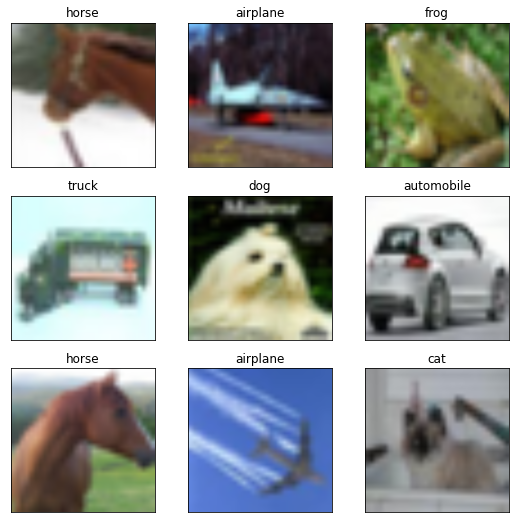

In [12]:
# Show some imags with their labels.
# images, labels = tfa.image.cutout_ops.random_cutout(batch['image'][0][:9], tuple([np.int32(0.5*x) for x in batch['image'][0][0].shape[:2]])), batch['label'][0][:9]
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

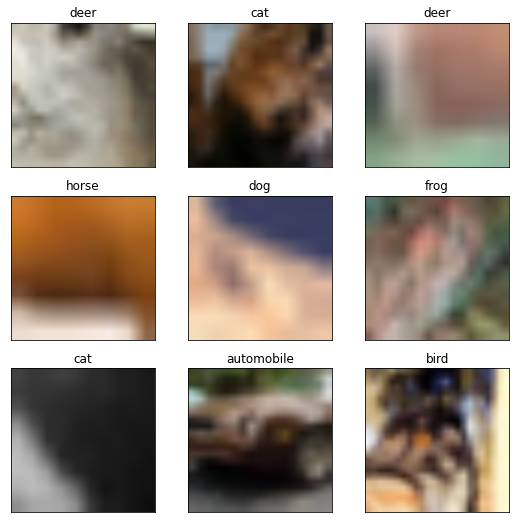

In [13]:
# Same as above, but with train images.
# Do you spot a difference?
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [26]:
# Load model definition & initialize random parameters.
VisionTransformer = models.KNOWN_MODELS[model].partial(num_classes=num_classes)
_, params = VisionTransformer.init_by_shape(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    [(batch['image'].shape[1:], batch['image'].dtype.name)])

In [27]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'./vit_models/imagenet21k+imagenet2012/{model}.npz',
    init_params=params,
    model_config=models.CONFIGS[model],
    logger=logger,
)

2020-11-28 21:59:26,729 [WARNING] vit_jax.logging: Inspect recovered empty keys:
{'pre_logits'}
2020-11-28 21:59:26,731 [INFO] vit_jax.logging: load_pretrained: drop-head variant


### Evaluate

In [28]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['cls']).__name__, params['cls'].shape)
print('params_repl.cls:', type(params_repl['cls']).__name__, params_repl['cls'].shape)

params.cls: ndarray (1, 1, 768)
params_repl.cls: ShardedDeviceArray (8, 1, 1, 768)


In [29]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(VisionTransformer.call)

In [30]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.notebook.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [19]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

2020-11-28 21:34:19,674 [INFO] absl: Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


DeviceArray(0.10063734, dtype=float32)

### Fine-tune

In [31]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 50
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [32]:
# Check out train.make_update_fn in the editor on the right side for details.
update_fn_repl = train.make_update_fn(VisionTransformer.call, accum_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

In [33]:
lr_fn = hyper.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# Prefetch entire learning rate schedule onto devices. Otherwise we would have
# a slow transfer from host to devices in every step.
lr_iter = hyper.lr_prefetch_iter(lr_fn, 0, total_steps)
# Initialize PRNGs for dropout.
update_rngs = jax.random.split(jax.random.PRNGKey(0), jax.local_device_count())

In [ ]:
# Training with data-augmentation

tf.compat.v1.enable_eager_execution

experiments = ['Baseline', 'Rotate', 'Cutout', 'Sobel Filtering', 'Gaussian Blur', 'Color Distortion', 'Gaussain Noise']

categories_cifar10 = ['airplane', 'automobile', 'bird', 'cat', 'dog', 'ship', 'truck']
categories_SIN = ['airplane', 'car', 'bird', 'cat', 'dog', 'boat', 'truck']

acc_cifar10 = []
shape_match = []
texture_match = []
shape_bias = []

# Calculating total images in SIN-subset
total_images = 0
for c in categories_SIN:
  for im in os.listdir("./stimuli/cue-conflict/" + c):

    shape_label = c
    texture_label = re.search('-(.*).png', im).group(1)[:-1]

    if texture_label not in categories_SIN: continue

    total_images += 1

for exp in range(0, len(experiments)):
  print(f'Running Experiment: {experiments[exp]}')

  lr_iter = hyper.lr_prefetch_iter(lr_fn, 0, total_steps)
  update_rngs = jax.random.split(jax.random.PRNGKey(0), jax.local_device_count())

  if exp == 0:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch, update_rngs)

  if exp == 1:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = tf.image.rot90(images[i], random.randint(1, 3))
        images[i] = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)

  if exp == 2:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = tfa.image.cutout_ops.random_cutout(images[i], tuple([np.int32(random.randrange(2, 192, 2)), np.int32(random.randrange(2, 192, 2))]))
        images[i] = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)

  if exp == 3:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = tfio.experimental.filter.sobel(images[i])
        images[i] = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)
  
  if exp == 4:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = tfa.image.gaussian_filter2d(images[i]) #, filter_shape = [30, 30], sigma = 5)
        images[i] = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)

  if exp == 5:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = data_util.random_color_jitter(images[i])
        images[i] = bi
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)

  if exp == 6:
    # Training loop
    for step, batch, lr_repl in zip(tqdm.notebook.trange(1, total_steps + 1), ds_train.as_numpy_iterator(), lr_iter):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = tf.clip_by_value(images[i] + tf.random_normal(shape=tf.shape(images[i]), mean=0.0, stddev=(50)/(255), dtype=tf.float32), 0.0, 1.0)
        images[i] = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt_repl, loss_repl, update_rngs = update_fn_repl(opt_repl, lr_repl, batch_new, update_rngs)

  exp_done = 'Baseline'
  for i in range(exp):
    exp_done = f'{exp_done}+{experiments[i+1]}'
  
  # Save model
  checkpoint.save(flax_utils.unreplicate(opt_repl.target), f'./vit_models/imagenet21k+imagenet2012+cifar10/{model}_{exp_done}.npz')

  # Accuracy on CIFAR-10
  print('Testing model on CIFAR-10')
  acc_cifar10.append(np.float(get_accuracy(opt_repl.target)))

  VisionTransformer = models.KNOWN_MODELS[model].partial(num_classes=num_classes)
  _, params = VisionTransformer.init_by_shape(jax.random.PRNGKey(0), [((1, 384, 384, 3), batch['image'].dtype.name)])
  checkpoint.load(f'./vit_models/imagenet21k+imagenet2012+cifar10/{model}_{exp_done}.npz')
  params['pre_logits'] = {}

  count = 0

  # SIN Test
  print('Running SIN Test')
  SIN_count = 0.0
  SIN_correct_shape = 0.0
  SIN_correct_texture = 0.0
  for c in categories_SIN:
    for im in os.listdir("./stimuli/cue-conflict/" + c + "/"):

      shape_label = c
      texture_label = re.search('-(.*).png', im).group(1)[:-1]

      if texture_label not in categories_SIN: continue

      img = cv2.imread("./stimuli/cue-conflict/" + c + "/" + im)
      img = cv2.resize(img, (384, 384))
      inp = (np.array(img) / 128 - 1)[None, ...]


      logits, = VisionTransformer.call(params, inp)
      preds = flax.nn.softmax(logits)

      pred = preds.argsort()[-1]

      pred_label = labelnames[dataset][pred]

      SIN_correct_shape += 1 if (categories_cifar10.index(pred_label) == categories_SIN.index(shape_label)) else 0
      SIN_correct_texture += 1 if (categories_cifar10.index(pred_label) == categories_SIN.index(texture_label)) else 0

      SIN_count += 1

      count += 1
      print('\r %0.2f%%' % (count/(total_images)*100), end='')
  
  shape_match.append(SIN_correct_shape / SIN_count)
  texture_match.append(SIN_correct_texture / SIN_count)
  shape_bias.append(shape_match[-1] / texture_match[-1])





Running Experiment: Baseline


2020-11-28 22:09:23,822 [INFO] absl: Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


Testing model on CIFAR-10



Running SIN Test
 15.51%

In [ ]:
with open(f'./results/fine-tune/vit_fine-tune.csv', mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    csv_writer.writerow(['Augmentation', 'Shape Bias', 'Shape Match', 'Texture Match', 'CIFAR-10 Accuracy'])
    for exp in range(len(experiments)):
      aug = experiments[exp] if exp == 0 else f'+{experiments[exp]}'
      csv_writer.writerow([aug, f'{shape_bias[exp]*100}%', f'{shape_match[exp]*100}%', f'{texture_match[exp]*100}%', f'{acc_cifar10[exp]*100}%'])